# Image Regression From Scratch: Image Augmentation for Regression

## Introduction
The Pawpularity Kaggle competition has a few aspects that make it unique: it is a regression problem with image features, and it includes features that describe *stylistic* aspects of the picture.

If you're anything like me, your first thought when approaching any problem with images is to somehow incorparate a pretrained network. We don't have much data to train on, and leveraging a pretrained network is a consistent way to overcome this problem.

Don't get me wrong, I will definitely be doing this at some point. But before I do, let's first try solving this problem from scratch. 

Regression with images is a rarity in practice, and many people assume that the same strategies used in image classification will translate directly to regression. But this is not always clear, and approaching this competition without a pretrained network provides an opportunity to see some of the potential risks and decisions that are encountered when applying standard techniques to a new problem.

Consider the task of creating synthetic data. In the world of image classification one of the most prominent methods of generating more data is through image augmentation: rotating the image, shifting the image, changing the brightness of the image, etc. The use of image augmentation is ubiquitous and many data scientits use it every time they train an image classifier. However, this method could potentially cause several issues in this particular problem. For instance, when you augment an image you often change some stylistic attributes of the image (focus, blur, etc.) and therefore change the values of some of our categorical features. More importantly, this is a regression problem, and not a classification problem. Changing the brightness on a cat picture does not change the fact that it's a cat, but it is entirely possible that changing the brightness of a cat picture will make it less likely to be Pawpular. So while transforming images can definitely give us more data, it's possible that it will give us poor data. 

This problem is particularly interesting because it cuts into the heart of the dichotomy betweeen two of the most foundational principles in machine learning:

    1. the more data the better
    2. garbage in, garbage out.
    
We always want as much data as possible when training any deep learning model, but what if this additional data is actually hurting us?

The question I will look to answer is the following: can image augmentation used to create a model to predict pawpularity from scratch?

I will attempt to answer this question with a small experiment, by comparing the accuracy of the following models:

    1. a basic convolutional neural network trained on only the image data, with data augmentation
    2. a basic convolutional neural network trained on only the image data, with no data augmentation
    3. a multi-input neural network with both image and categorical features, with no data augmentation.
    
Note: It is likely that the first model can be improved by identifying which categorical features are invariant through the various data augmentation methods, and keeping these features. This is beyond the scope of our investigation. Additionally, to truly answer the question it would be best to test different types of augmentations - what if, for instance, vertically shifting an image isn't likely to change its pawpularity but rotating it is? This too is beyong the scope of our investigation. The transformation we will include are rotating by up to 30 degrees, shifting vertically and horizontally by up to 10%, zooming by up to 20%, and flipping horizontally, but these decisions are certainly questionable.


We begin by investigating our dataset and identifying which categorical features are unlikely to help our model. Secondly, we will train a standard convolutional neural network on an augmented version of our image dataset. Thirdly, we will train a multi-input neural network with no image augmentation performed. We will end by comparing the results, tweaking models, and making some final statements.

Let's begin.

***

## EDA, Data Visualizations, and Feature Selection

Load the data and take a look at some pictures.

In [45]:
import time
import math
import json
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf

import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.set_printoptions(threshold=2**31-1)
sns.set_theme()


In [46]:
# Define constants.
notebook_start_time = time.time()
folder_path = ''
train_folder = folder_path + 'train/'
train_filename = folder_path + 'train.csv'
test_folder = folder_path + 'test/'
test_filename = folder_path + 'test.csv'

EPOCHS = 25
BATCH_SIZE = 32


In [47]:
# Read training data.
df = pd.read_csv(train_filename)

# Change Id to file location of image.
df['image'] = df['Id'].map(lambda id: id + '.jpg')

# We won't use Id for any of our EDA, and can drop it now.
df.drop(columns=['Id'], inplace=True)


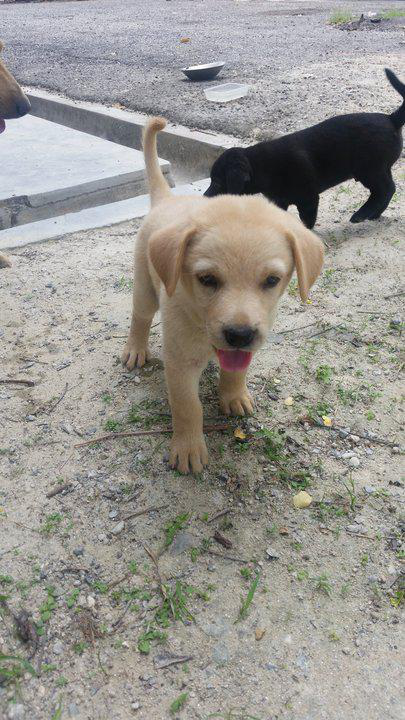

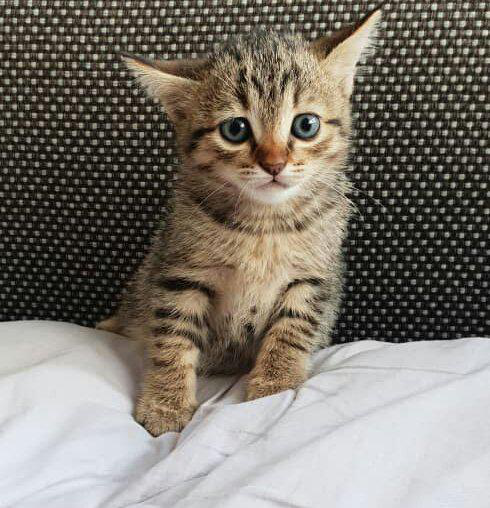

In [48]:
# Display images using the PIL package.
image1_path = folder_path + 'train/' + df['image'][0]
image1 = Image.open(image1_path)
image1.load()
display(image1)

image2_path = folder_path + 'train/' + df['image'][48]
image2 = Image.open(image2_path)
image2.load()
display(image2)


If every picture is that cute then this dataset is going to be very positively skewed! Next we take a high level look at our data by looking for null values, showing data types, and showing distributions.


Number of samples: 9912
Dataframe has no missing values.

Feature data types:
Data type: int64
Count: 13

Data type: object
Count: 1



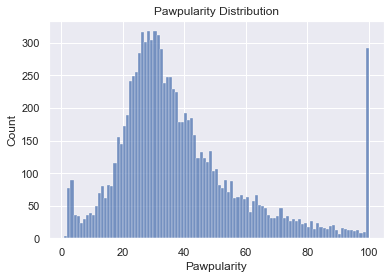

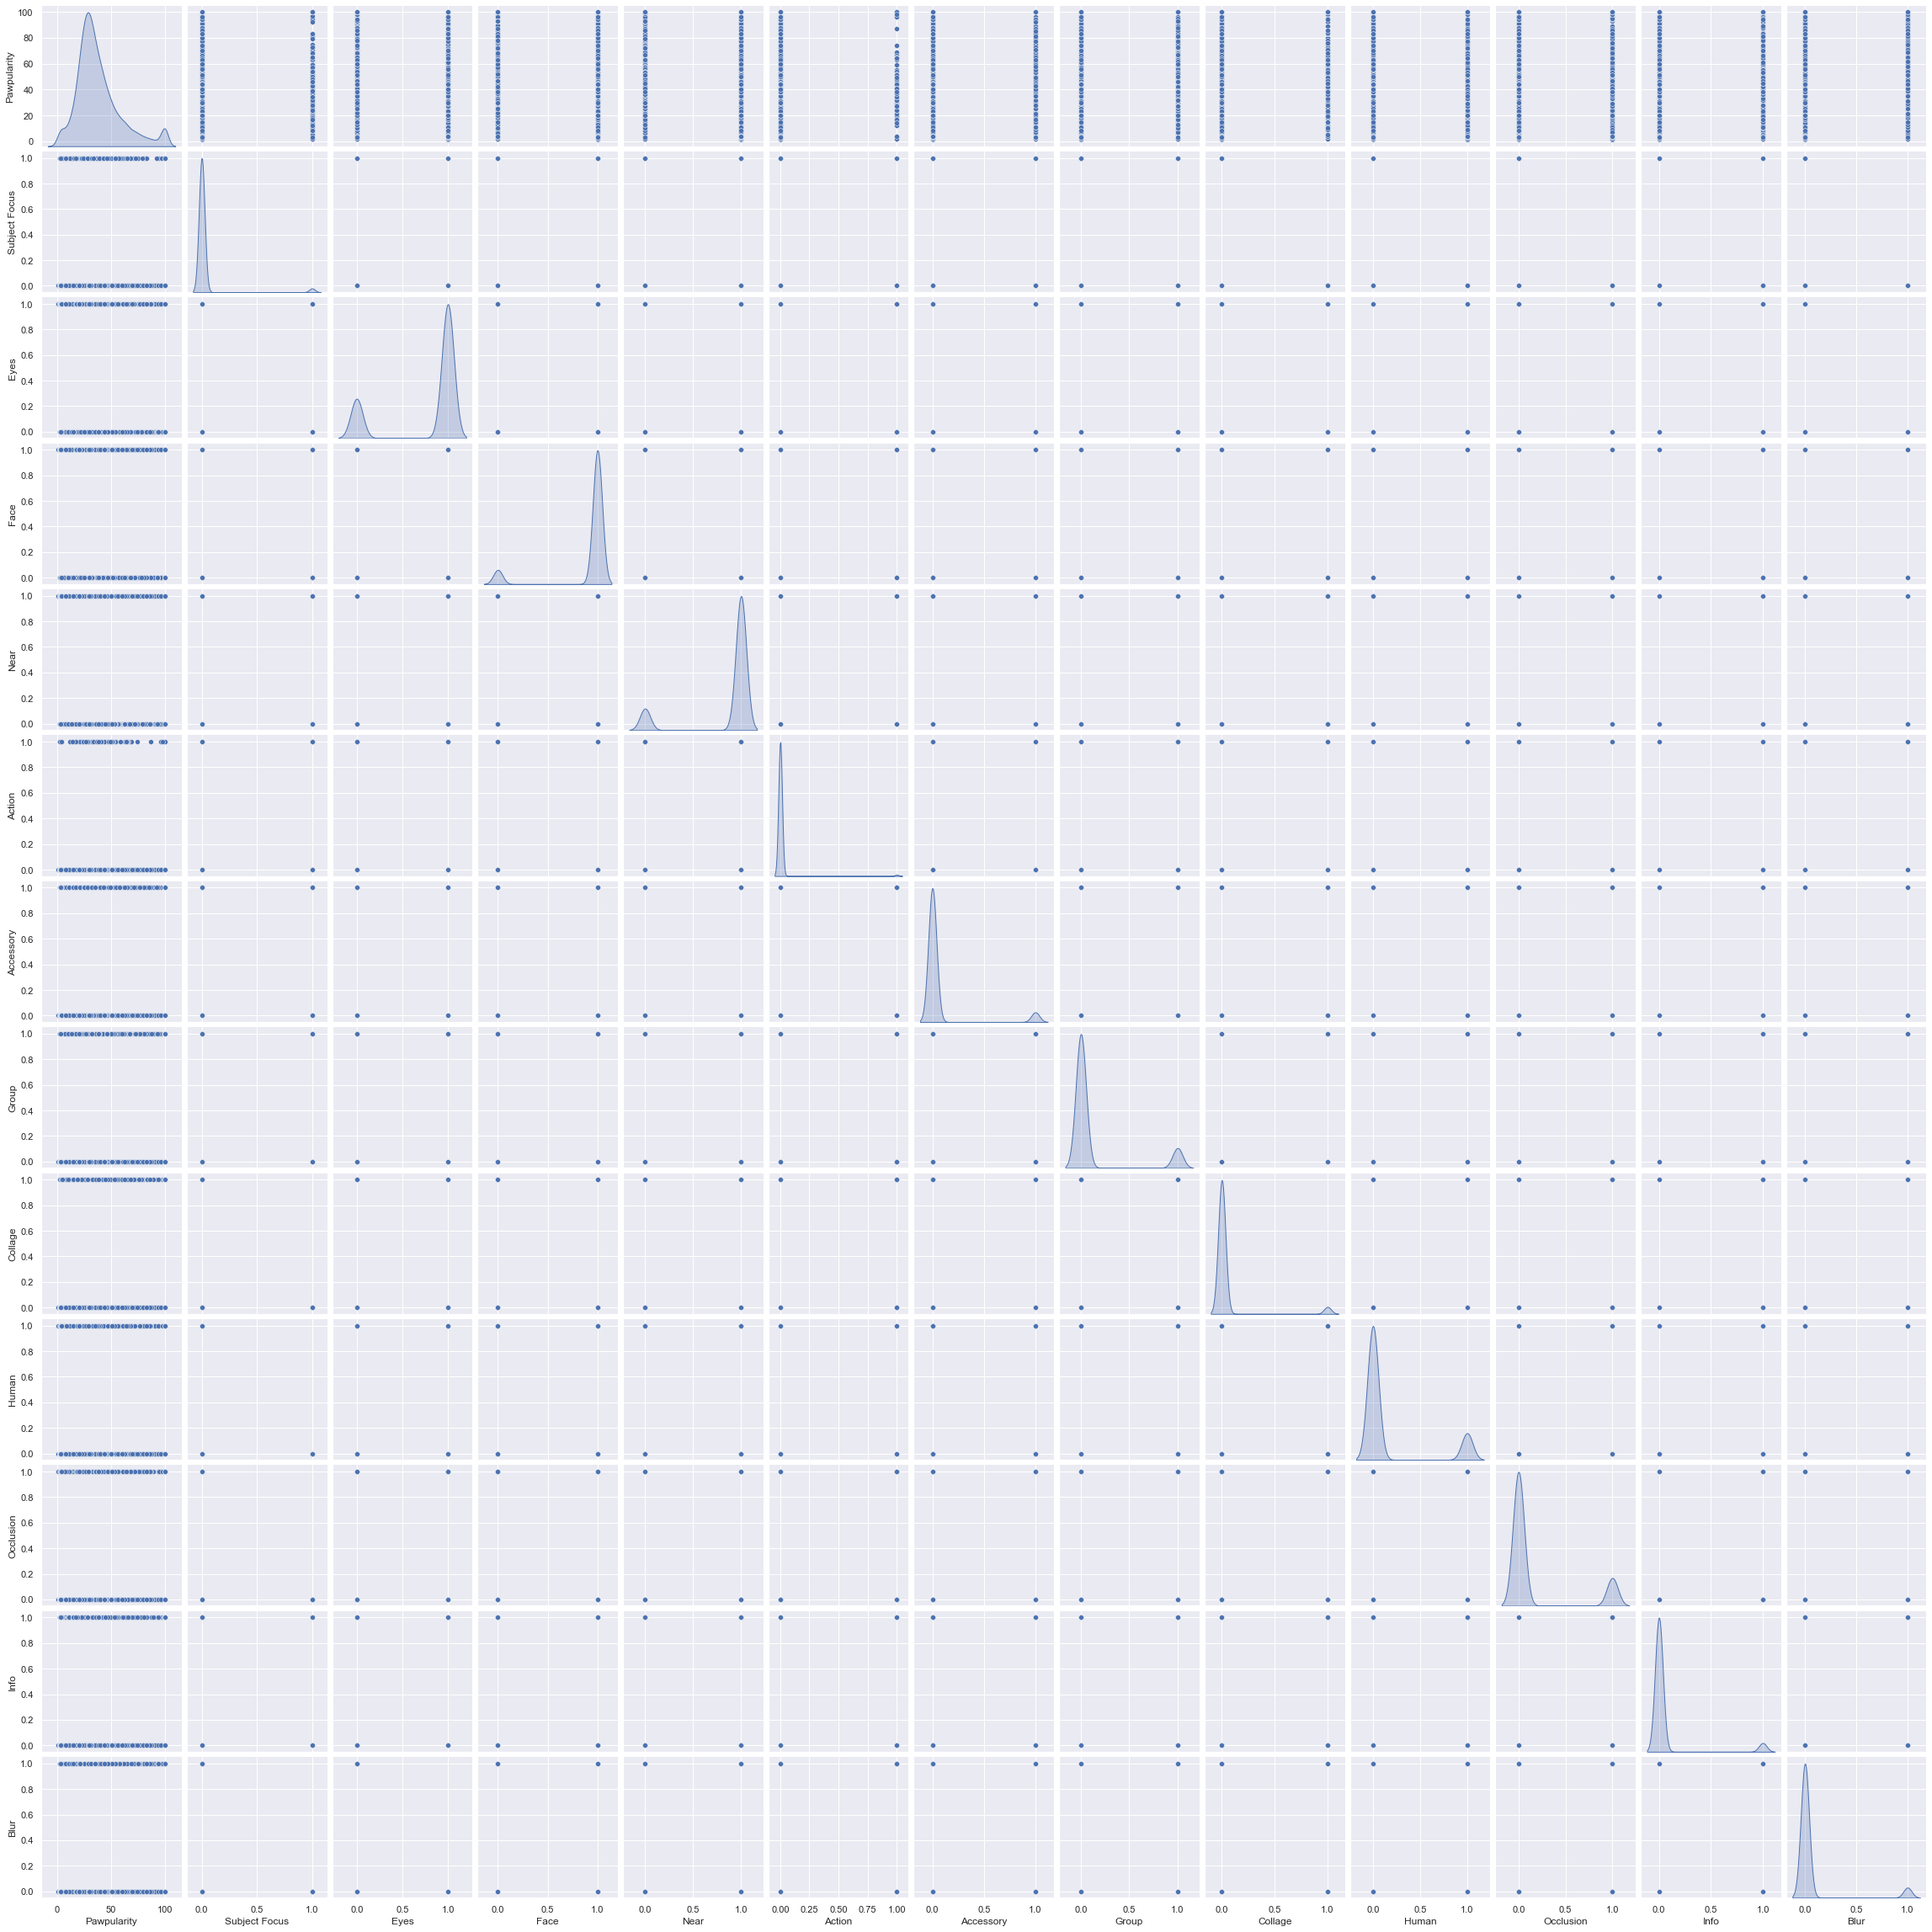

In [49]:
# Define function to look for null values, count number of columns by datatype, and plot label distribution.
def autoEDA(df:pd.DataFrame, label_name:str=None, label_plot:bool=False, pair_plot:bool=False):
    """General function to perform basic EDA.
    Option to plot label distribution or include pairplot whose first row corresponds to the label.
    label_name must be specified to include pairplot.
    Args:
        df (pd.DataFrame): [description]
        label_name (str, optional): Provide label name for plots. Defaults to None.
        label_plot (bool, optional): Returns plot of label distribution when True. Defaults to False.
        pair_plot (bool, optional): Returns pairplot when True. Defaults to False.
    """
    # Find and print the number of samples.
    n_samples = df.shape[0]
    print()
    print(f'Number of samples: {n_samples}')
    
    # Find the number of null values per column.
    na_counts = pd.DataFrame(df.isna().sum())
    
    # Select columns with any null values.
    features_na = na_counts[na_counts[0] > 0]
    
    # Print any features with missing values.
    if features_na.shape[0] > 0:
        for column, count in features_na.iterrows():
            print('Feature:', column, 'Number of NA:', count)
            print()
    else:
        print('Dataframe has no missing values.')
        print()
    
    # If label_plot is True, plot the label distribution.
    if label_plot:
        sns.histplot(
            df[label_name],
            binwidth=1
        ).set(title='Pawpularity Distribution')
        
    # If pair_plot is True, create pairplot with label on first row.
    if pair_plot:
        df_features = df.drop(columns=[label_name])
        # Select numeric features.
        df_numeric = df_features.select_dtypes(include='number')
        numeric_cols = df_numeric.columns
        plot_cols = [label_name] + list(numeric_cols) 
        
        sns.pairplot(
            df[plot_cols],
            diag_kind='kde'
        )

    # Create dataframe with the number of features by data type.
    df_datatypes = pd.DataFrame(df.dtypes.value_counts())
    
    # Print the counts of each data type.
    print('Feature data types:')
    for dtype, count in df_datatypes.iterrows():
        print('Data type:', dtype)
        print('Count:', count[0])
        print()

autoEDA(df, label_name='Pawpularity', label_plot=True, pair_plot=True)


We can see that all features other than our images are binary categorical variables, and all have an unreprepresented category. Our third model will use these categorical features, so we will explore them now and select which to keep.


In [50]:
from itertools import combinations

cols_categorical = [col for col in df.columns if col not in ['Pawpularity', 'image']]

for col_tup in combinations(cols_categorical, 2):
    x = col_tup[0]
    y = col_tup[1]

    df_contingency = pd.crosstab(index=df[x], columns=df[y], margins=True)
    df_contingency_normalized = pd.crosstab(index=df[x], columns=df[y], margins=True, normalize='all')

    print(f'Contingency Table: {x} vs. {y}')
    display(df_contingency.head(df_contingency.shape[0]))
    print()

    print(f'Normalized Contingency Table: {x} vs. {y}')
    display(df_contingency_normalized.head(df_contingency.shape[0]))
    print()


Contingency Table: Subject Focus vs. Eyes


Eyes,0,1,All
Subject Focus,,,
0,2244,7394,9638
1,10,264,274
All,2254,7658,9912



Normalized Contingency Table: Subject Focus vs. Eyes


Eyes,0,1,All
Subject Focus,,,
0,0.226392,0.745964,0.972357
1,0.001009,0.026634,0.027643
All,0.227401,0.772599,1.000000



Contingency Table: Subject Focus vs. Face


Face,0,1,All
Subject Focus,,,
0,944,8694,9638
1,8,266,274
All,952,8960,9912



Normalized Contingency Table: Subject Focus vs. Face


Face,0,1,All
Subject Focus,,,
0,0.095238,0.877119,0.972357
1,0.000807,0.026836,0.027643
All,0.096045,0.903955,1.000000



Contingency Table: Subject Focus vs. Near


Near,0,1,All
Subject Focus,,,
0,1367,8271,9638
1,5,269,274
All,1372,8540,9912



Normalized Contingency Table: Subject Focus vs. Near


Near,0,1,All
Subject Focus,,,
0,0.137914,0.834443,0.972357
1,0.000504,0.027139,0.027643
All,0.138418,0.861582,1.000000



Contingency Table: Subject Focus vs. Action


Action,0,1,All
Subject Focus,,,
0,9544,94,9638
1,269,5,274
All,9813,99,9912



Normalized Contingency Table: Subject Focus vs. Action


Action,0,1,All
Subject Focus,,,
0,0.962873,0.009483,0.972357
1,0.027139,0.000504,0.027643
All,0.990012,0.009988,1.000000



Contingency Table: Subject Focus vs. Accessory


Accessory,0,1,All
Subject Focus,,,
0,8993,645,9638
1,247,27,274
All,9240,672,9912



Normalized Contingency Table: Subject Focus vs. Accessory


Accessory,0,1,All
Subject Focus,,,
0,0.907284,0.065073,0.972357
1,0.024919,0.002724,0.027643
All,0.932203,0.067797,1.000000



Contingency Table: Subject Focus vs. Group


Group,0,1,All
Subject Focus,,,
0,8363,1275,9638
1,267,7,274
All,8630,1282,9912



Normalized Contingency Table: Subject Focus vs. Group


Group,0,1,All
Subject Focus,,,
0,0.843725,0.128632,0.972357
1,0.026937,0.000706,0.027643
All,0.870662,0.129338,1.000000



Contingency Table: Subject Focus vs. Collage


Collage,0,1,All
Subject Focus,,,
0,9146,492,9638
1,274,0,274
All,9420,492,9912



Normalized Contingency Table: Subject Focus vs. Collage


Collage,0,1,All
Subject Focus,,,
0,0.922720,0.049637,0.972357
1,0.027643,0.000000,0.027643
All,0.950363,0.049637,1.000000



Contingency Table: Subject Focus vs. Human


Human,0,1,All
Subject Focus,,,
0,7990,1648,9638
1,274,0,274
All,8264,1648,9912



Normalized Contingency Table: Subject Focus vs. Human


Human,0,1,All
Subject Focus,,,
0,0.806094,0.166263,0.972357
1,0.027643,0.000000,0.027643
All,0.833737,0.166263,1.000000



Contingency Table: Subject Focus vs. Occlusion


Occlusion,0,1,All
Subject Focus,,,
0,7933,1705,9638
1,274,0,274
All,8207,1705,9912



Normalized Contingency Table: Subject Focus vs. Occlusion


Occlusion,0,1,All
Subject Focus,,,
0,0.800343,0.172014,0.972357
1,0.027643,0.000000,0.027643
All,0.827986,0.172014,1.000000



Contingency Table: Subject Focus vs. Info


Info,0,1,All
Subject Focus,,,
0,9032,606,9638
1,273,1,274
All,9305,607,9912



Normalized Contingency Table: Subject Focus vs. Info


Info,0,1,All
Subject Focus,,,
0,0.911219,0.061138,0.972357
1,0.027542,0.000101,0.027643
All,0.938761,0.061239,1.000000



Contingency Table: Subject Focus vs. Blur


Blur,0,1,All
Subject Focus,,,
0,8940,698,9638
1,274,0,274
All,9214,698,9912



Normalized Contingency Table: Subject Focus vs. Blur


Blur,0,1,All
Subject Focus,,,
0,0.901937,0.07042,0.972357
1,0.027643,0.00000,0.027643
All,0.929580,0.07042,1.000000



Contingency Table: Eyes vs. Face


Face,0,1,All
Eyes,,,
0,932,1322,2254
1,20,7638,7658
All,952,8960,9912



Normalized Contingency Table: Eyes vs. Face


Face,0,1,All
Eyes,,,
0,0.094027,0.133374,0.227401
1,0.002018,0.770581,0.772599
All,0.096045,0.903955,1.000000



Contingency Table: Eyes vs. Near


Near,0,1,All
Eyes,,,
0,503,1751,2254
1,869,6789,7658
All,1372,8540,9912



Normalized Contingency Table: Eyes vs. Near


Near,0,1,All
Eyes,,,
0,0.050747,0.176655,0.227401
1,0.087672,0.684927,0.772599
All,0.138418,0.861582,1.000000



Contingency Table: Eyes vs. Action


Action,0,1,All
Eyes,,,
0,2223,31,2254
1,7590,68,7658
All,9813,99,9912



Normalized Contingency Table: Eyes vs. Action


Action,0,1,All
Eyes,,,
0,0.224274,0.003128,0.227401
1,0.765738,0.006860,0.772599
All,0.990012,0.009988,1.000000



Contingency Table: Eyes vs. Accessory


Accessory,0,1,All
Eyes,,,
0,2156,98,2254
1,7084,574,7658
All,9240,672,9912



Normalized Contingency Table: Eyes vs. Accessory


Accessory,0,1,All
Eyes,,,
0,0.217514,0.009887,0.227401
1,0.714689,0.057910,0.772599
All,0.932203,0.067797,1.000000



Contingency Table: Eyes vs. Group


Group,0,1,All
Eyes,,,
0,1844,410,2254
1,6786,872,7658
All,8630,1282,9912



Normalized Contingency Table: Eyes vs. Group


Group,0,1,All
Eyes,,,
0,0.186037,0.041364,0.227401
1,0.684625,0.087974,0.772599
All,0.870662,0.129338,1.000000



Contingency Table: Eyes vs. Collage


Collage,0,1,All
Eyes,,,
0,2202,52,2254
1,7218,440,7658
All,9420,492,9912



Normalized Contingency Table: Eyes vs. Collage


Collage,0,1,All
Eyes,,,
0,0.222155,0.005246,0.227401
1,0.728208,0.044391,0.772599
All,0.950363,0.049637,1.000000



Contingency Table: Eyes vs. Human


Human,0,1,All
Eyes,,,
0,1935,319,2254
1,6329,1329,7658
All,8264,1648,9912



Normalized Contingency Table: Eyes vs. Human


Human,0,1,All
Eyes,,,
0,0.195218,0.032183,0.227401
1,0.638519,0.134080,0.772599
All,0.833737,0.166263,1.000000



Contingency Table: Eyes vs. Occlusion


Occlusion,0,1,All
Eyes,,,
0,1901,353,2254
1,6306,1352,7658
All,8207,1705,9912



Normalized Contingency Table: Eyes vs. Occlusion


Occlusion,0,1,All
Eyes,,,
0,0.191788,0.035613,0.227401
1,0.636199,0.136400,0.772599
All,0.827986,0.172014,1.000000



Contingency Table: Eyes vs. Info


Info,0,1,All
Eyes,,,
0,2154,100,2254
1,7151,507,7658
All,9305,607,9912



Normalized Contingency Table: Eyes vs. Info


Info,0,1,All
Eyes,,,
0,0.217312,0.010089,0.227401
1,0.721449,0.051150,0.772599
All,0.938761,0.061239,1.000000



Contingency Table: Eyes vs. Blur


Blur,0,1,All
Eyes,,,
0,1556,698,2254
1,7658,0,7658
All,9214,698,9912



Normalized Contingency Table: Eyes vs. Blur


Blur,0,1,All
Eyes,,,
0,0.156981,0.07042,0.227401
1,0.772599,0.00000,0.772599
All,0.929580,0.07042,1.000000



Contingency Table: Face vs. Near


Near,0,1,All
Face,,,
0,272,680,952
1,1100,7860,8960
All,1372,8540,9912



Normalized Contingency Table: Face vs. Near


Near,0,1,All
Face,,,
0,0.027441,0.068604,0.096045
1,0.110977,0.792978,0.903955
All,0.138418,0.861582,1.000000



Contingency Table: Face vs. Action


Action,0,1,All
Face,,,
0,939,13,952
1,8874,86,8960
All,9813,99,9912



Normalized Contingency Table: Face vs. Action


Action,0,1,All
Face,,,
0,0.094734,0.001312,0.096045
1,0.895278,0.008676,0.903955
All,0.990012,0.009988,1.000000



Contingency Table: Face vs. Accessory


Accessory,0,1,All
Face,,,
0,913,39,952
1,8327,633,8960
All,9240,672,9912



Normalized Contingency Table: Face vs. Accessory


Accessory,0,1,All
Face,,,
0,0.092111,0.003935,0.096045
1,0.840093,0.063862,0.903955
All,0.932203,0.067797,1.000000



Contingency Table: Face vs. Group


Group,0,1,All
Face,,,
0,723,229,952
1,7907,1053,8960
All,8630,1282,9912



Normalized Contingency Table: Face vs. Group


Group,0,1,All
Face,,,
0,0.072942,0.023103,0.096045
1,0.797720,0.106235,0.903955
All,0.870662,0.129338,1.000000



Contingency Table: Face vs. Collage


Collage,0,1,All
Face,,,
0,937,15,952
1,8483,477,8960
All,9420,492,9912



Normalized Contingency Table: Face vs. Collage


Collage,0,1,All
Face,,,
0,0.094532,0.001513,0.096045
1,0.855831,0.048123,0.903955
All,0.950363,0.049637,1.000000



Contingency Table: Face vs. Human


Human,0,1,All
Face,,,
0,820,132,952
1,7444,1516,8960
All,8264,1648,9912



Normalized Contingency Table: Face vs. Human


Human,0,1,All
Face,,,
0,0.082728,0.013317,0.096045
1,0.751009,0.152946,0.903955
All,0.833737,0.166263,1.000000



Contingency Table: Face vs. Occlusion


Occlusion,0,1,All
Face,,,
0,803,149,952
1,7404,1556,8960
All,8207,1705,9912



Normalized Contingency Table: Face vs. Occlusion


Occlusion,0,1,All
Face,,,
0,0.081013,0.015032,0.096045
1,0.746973,0.156981,0.903955
All,0.827986,0.172014,1.000000



Contingency Table: Face vs. Info


Info,0,1,All
Face,,,
0,911,41,952
1,8394,566,8960
All,9305,607,9912



Normalized Contingency Table: Face vs. Info


Info,0,1,All
Face,,,
0,0.091909,0.004136,0.096045
1,0.846852,0.057103,0.903955
All,0.938761,0.061239,1.000000



Contingency Table: Face vs. Blur


Blur,0,1,All
Face,,,
0,834,118,952
1,8380,580,8960
All,9214,698,9912



Normalized Contingency Table: Face vs. Blur


Blur,0,1,All
Face,,,
0,0.08414,0.011905,0.096045
1,0.84544,0.058515,0.903955
All,0.92958,0.070420,1.000000



Contingency Table: Near vs. Action


Action,0,1,All
Near,,,
0,1349,23,1372
1,8464,76,8540
All,9813,99,9912



Normalized Contingency Table: Near vs. Action


Action,0,1,All
Near,,,
0,0.136098,0.002320,0.138418
1,0.853914,0.007667,0.861582
All,0.990012,0.009988,1.000000



Contingency Table: Near vs. Accessory


Accessory,0,1,All
Near,,,
0,1305,67,1372
1,7935,605,8540
All,9240,672,9912



Normalized Contingency Table: Near vs. Accessory


Accessory,0,1,All
Near,,,
0,0.131659,0.006759,0.138418
1,0.800545,0.061037,0.861582
All,0.932203,0.067797,1.000000



Contingency Table: Near vs. Group


Group,0,1,All
Near,,,
0,828,544,1372
1,7802,738,8540
All,8630,1282,9912



Normalized Contingency Table: Near vs. Group


Group,0,1,All
Near,,,
0,0.083535,0.054883,0.138418
1,0.787127,0.074455,0.861582
All,0.870662,0.129338,1.000000



Contingency Table: Near vs. Collage


Collage,0,1,All
Near,,,
0,1108,264,1372
1,8312,228,8540
All,9420,492,9912



Normalized Contingency Table: Near vs. Collage


Collage,0,1,All
Near,,,
0,0.111784,0.026634,0.138418
1,0.838579,0.023002,0.861582
All,0.950363,0.049637,1.000000



Contingency Table: Near vs. Human


Human,0,1,All
Near,,,
0,1227,145,1372
1,7037,1503,8540
All,8264,1648,9912



Normalized Contingency Table: Near vs. Human


Human,0,1,All
Near,,,
0,0.123789,0.014629,0.138418
1,0.709948,0.151634,0.861582
All,0.833737,0.166263,1.000000



Contingency Table: Near vs. Occlusion


Occlusion,0,1,All
Near,,,
0,1124,248,1372
1,7083,1457,8540
All,8207,1705,9912



Normalized Contingency Table: Near vs. Occlusion


Occlusion,0,1,All
Near,,,
0,0.113398,0.025020,0.138418
1,0.714588,0.146994,0.861582
All,0.827986,0.172014,1.000000



Contingency Table: Near vs. Info


Info,0,1,All
Near,,,
0,1168,204,1372
1,8137,403,8540
All,9305,607,9912



Normalized Contingency Table: Near vs. Info


Info,0,1,All
Near,,,
0,0.117837,0.020581,0.138418
1,0.820924,0.040658,0.861582
All,0.938761,0.061239,1.000000



Contingency Table: Near vs. Blur


Blur,0,1,All
Near,,,
0,1260,112,1372
1,7954,586,8540
All,9214,698,9912



Normalized Contingency Table: Near vs. Blur


Blur,0,1,All
Near,,,
0,0.127119,0.011299,0.138418
1,0.802462,0.059120,0.861582
All,0.929580,0.070420,1.000000



Contingency Table: Action vs. Accessory


Accessory,0,1,All
Action,,,
0,9154,659,9813
1,86,13,99
All,9240,672,9912



Normalized Contingency Table: Action vs. Accessory


Accessory,0,1,All
Action,,,
0,0.923527,0.066485,0.990012
1,0.008676,0.001312,0.009988
All,0.932203,0.067797,1.000000



Contingency Table: Action vs. Group


Group,0,1,All
Action,,,
0,8543,1270,9813
1,87,12,99
All,8630,1282,9912



Normalized Contingency Table: Action vs. Group


Group,0,1,All
Action,,,
0,0.861885,0.128128,0.990012
1,0.008777,0.001211,0.009988
All,0.870662,0.129338,1.000000



Contingency Table: Action vs. Collage


Collage,0,1,All
Action,,,
0,9325,488,9813
1,95,4,99
All,9420,492,9912



Normalized Contingency Table: Action vs. Collage


Collage,0,1,All
Action,,,
0,0.940779,0.049233,0.990012
1,0.009584,0.000404,0.009988
All,0.950363,0.049637,1.000000



Contingency Table: Action vs. Human


Human,0,1,All
Action,,,
0,8178,1635,9813
1,86,13,99
All,8264,1648,9912



Normalized Contingency Table: Action vs. Human


Human,0,1,All
Action,,,
0,0.825061,0.164952,0.990012
1,0.008676,0.001312,0.009988
All,0.833737,0.166263,1.000000



Contingency Table: Action vs. Occlusion


Occlusion,0,1,All
Action,,,
0,8121,1692,9813
1,86,13,99
All,8207,1705,9912



Normalized Contingency Table: Action vs. Occlusion


Occlusion,0,1,All
Action,,,
0,0.819310,0.170702,0.990012
1,0.008676,0.001312,0.009988
All,0.827986,0.172014,1.000000



Contingency Table: Action vs. Info


Info,0,1,All
Action,,,
0,9208,605,9813
1,97,2,99
All,9305,607,9912



Normalized Contingency Table: Action vs. Info


Info,0,1,All
Action,,,
0,0.928975,0.061037,0.990012
1,0.009786,0.000202,0.009988
All,0.938761,0.061239,1.000000



Contingency Table: Action vs. Blur


Blur,0,1,All
Action,,,
0,9125,688,9813
1,89,10,99
All,9214,698,9912



Normalized Contingency Table: Action vs. Blur


Blur,0,1,All
Action,,,
0,0.920601,0.069411,0.990012
1,0.008979,0.001009,0.009988
All,0.929580,0.070420,1.000000



Contingency Table: Accessory vs. Group


Group,0,1,All
Accessory,,,
0,7997,1243,9240
1,633,39,672
All,8630,1282,9912



Normalized Contingency Table: Accessory vs. Group


Group,0,1,All
Accessory,,,
0,0.806800,0.125404,0.932203
1,0.063862,0.003935,0.067797
All,0.870662,0.129338,1.000000



Contingency Table: Accessory vs. Collage


Collage,0,1,All
Accessory,,,
0,8817,423,9240
1,603,69,672
All,9420,492,9912



Normalized Contingency Table: Accessory vs. Collage


Collage,0,1,All
Accessory,,,
0,0.889528,0.042676,0.932203
1,0.060835,0.006961,0.067797
All,0.950363,0.049637,1.000000



Contingency Table: Accessory vs. Human


Human,0,1,All
Accessory,,,
0,7665,1575,9240
1,599,73,672
All,8264,1648,9912



Normalized Contingency Table: Accessory vs. Human


Human,0,1,All
Accessory,,,
0,0.773305,0.158898,0.932203
1,0.060432,0.007365,0.067797
All,0.833737,0.166263,1.000000



Contingency Table: Accessory vs. Occlusion


Occlusion,0,1,All
Accessory,,,
0,7614,1626,9240
1,593,79,672
All,8207,1705,9912



Normalized Contingency Table: Accessory vs. Occlusion


Occlusion,0,1,All
Accessory,,,
0,0.768160,0.164044,0.932203
1,0.059826,0.007970,0.067797
All,0.827986,0.172014,1.000000



Contingency Table: Accessory vs. Info


Info,0,1,All
Accessory,,,
0,8719,521,9240
1,586,86,672
All,9305,607,9912



Normalized Contingency Table: Accessory vs. Info


Info,0,1,All
Accessory,,,
0,0.879641,0.052563,0.932203
1,0.059120,0.008676,0.067797
All,0.938761,0.061239,1.000000



Contingency Table: Accessory vs. Blur


Blur,0,1,All
Accessory,,,
0,8567,673,9240
1,647,25,672
All,9214,698,9912



Normalized Contingency Table: Accessory vs. Blur


Blur,0,1,All
Accessory,,,
0,0.864306,0.067897,0.932203
1,0.065274,0.002522,0.067797
All,0.929580,0.070420,1.000000



Contingency Table: Group vs. Collage


Collage,0,1,All
Group,,,
0,8297,333,8630
1,1123,159,1282
All,9420,492,9912



Normalized Contingency Table: Group vs. Collage


Collage,0,1,All
Group,,,
0,0.837066,0.033596,0.870662
1,0.113297,0.016041,0.129338
All,0.950363,0.049637,1.000000



Contingency Table: Group vs. Human


Human,0,1,All
Group,,,
0,7066,1564,8630
1,1198,84,1282
All,8264,1648,9912



Normalized Contingency Table: Group vs. Human


Human,0,1,All
Group,,,
0,0.712873,0.157789,0.870662
1,0.120864,0.008475,0.129338
All,0.833737,0.166263,1.000000



Contingency Table: Group vs. Occlusion


Occlusion,0,1,All
Group,,,
0,7150,1480,8630
1,1057,225,1282
All,8207,1705,9912



Normalized Contingency Table: Group vs. Occlusion


Occlusion,0,1,All
Group,,,
0,0.721348,0.149314,0.870662
1,0.106638,0.022700,0.129338
All,0.827986,0.172014,1.000000



Contingency Table: Group vs. Info


Info,0,1,All
Group,,,
0,8152,478,8630
1,1153,129,1282
All,9305,607,9912



Normalized Contingency Table: Group vs. Info


Info,0,1,All
Group,,,
0,0.822437,0.048224,0.870662
1,0.116324,0.013015,0.129338
All,0.938761,0.061239,1.000000



Contingency Table: Group vs. Blur


Blur,0,1,All
Group,,,
0,8029,601,8630
1,1185,97,1282
All,9214,698,9912



Normalized Contingency Table: Group vs. Blur


Blur,0,1,All
Group,,,
0,0.810028,0.060634,0.870662
1,0.119552,0.009786,0.129338
All,0.929580,0.070420,1.000000



Contingency Table: Collage vs. Human


Human,0,1,All
Collage,,,
0,7863,1557,9420
1,401,91,492
All,8264,1648,9912



Normalized Contingency Table: Collage vs. Human


Human,0,1,All
Collage,,,
0,0.793281,0.157082,0.950363
1,0.040456,0.009181,0.049637
All,0.833737,0.166263,1.000000



Contingency Table: Collage vs. Occlusion


Occlusion,0,1,All
Collage,,,
0,7844,1576,9420
1,363,129,492
All,8207,1705,9912



Normalized Contingency Table: Collage vs. Occlusion


Occlusion,0,1,All
Collage,,,
0,0.791364,0.158999,0.950363
1,0.036622,0.013015,0.049637
All,0.827986,0.172014,1.000000



Contingency Table: Collage vs. Info


Info,0,1,All
Collage,,,
0,9092,328,9420
1,213,279,492
All,9305,607,9912



Normalized Contingency Table: Collage vs. Info


Info,0,1,All
Collage,,,
0,0.917272,0.033091,0.950363
1,0.021489,0.028148,0.049637
All,0.938761,0.061239,1.000000



Contingency Table: Collage vs. Blur


Blur,0,1,All
Collage,,,
0,8742,678,9420
1,472,20,492
All,9214,698,9912



Normalized Contingency Table: Collage vs. Blur


Blur,0,1,All
Collage,,,
0,0.881961,0.068402,0.950363
1,0.047619,0.002018,0.049637
All,0.929580,0.070420,1.000000



Contingency Table: Human vs. Occlusion


Occlusion,0,1,All
Human,,,
0,7726,538,8264
1,481,1167,1648
All,8207,1705,9912



Normalized Contingency Table: Human vs. Occlusion


Occlusion,0,1,All
Human,,,
0,0.779459,0.054278,0.833737
1,0.048527,0.117736,0.166263
All,0.827986,0.172014,1.000000



Contingency Table: Human vs. Info


Info,0,1,All
Human,,,
0,7774,490,8264
1,1531,117,1648
All,9305,607,9912



Normalized Contingency Table: Human vs. Info


Info,0,1,All
Human,,,
0,0.784302,0.049435,0.833737
1,0.154459,0.011804,0.166263
All,0.938761,0.061239,1.000000



Contingency Table: Human vs. Blur


Blur,0,1,All
Human,,,
0,7667,597,8264
1,1547,101,1648
All,9214,698,9912



Normalized Contingency Table: Human vs. Blur


Blur,0,1,All
Human,,,
0,0.773507,0.06023,0.833737
1,0.156073,0.01019,0.166263
All,0.929580,0.07042,1.000000



Contingency Table: Occlusion vs. Info


Info,0,1,All
Occlusion,,,
0,7810,397,8207
1,1495,210,1705
All,9305,607,9912



Normalized Contingency Table: Occlusion vs. Info


Info,0,1,All
Occlusion,,,
0,0.787934,0.040052,0.827986
1,0.150827,0.021186,0.172014
All,0.938761,0.061239,1.000000



Contingency Table: Occlusion vs. Blur


Blur,0,1,All
Occlusion,,,
0,7623,584,8207
1,1591,114,1705
All,9214,698,9912



Normalized Contingency Table: Occlusion vs. Blur


Blur,0,1,All
Occlusion,,,
0,0.769068,0.058918,0.827986
1,0.160513,0.011501,0.172014
All,0.929580,0.070420,1.000000



Contingency Table: Info vs. Blur


Blur,0,1,All
Info,,,
0,8636,669,9305
1,578,29,607
All,9214,698,9912



Normalized Contingency Table: Info vs. Blur


Blur,0,1,All
Info,,,
0,0.871267,0.067494,0.938761
1,0.058313,0.002926,0.061239
All,0.929580,0.070420,1.000000


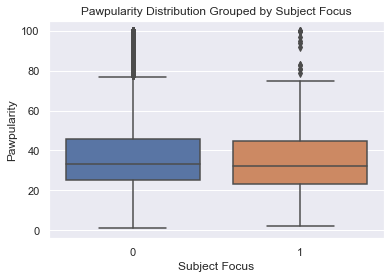

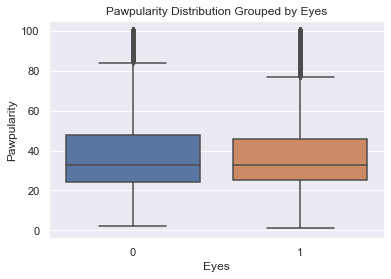

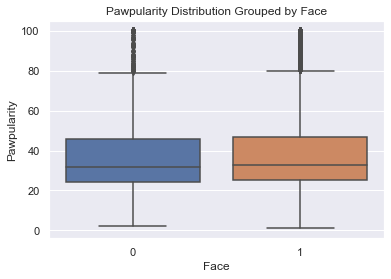

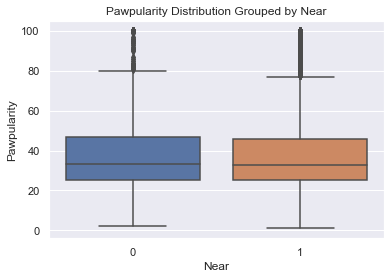

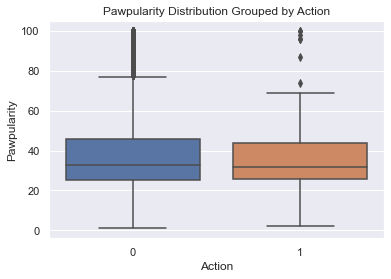

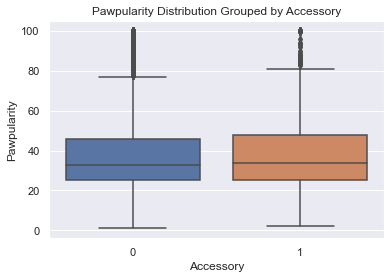

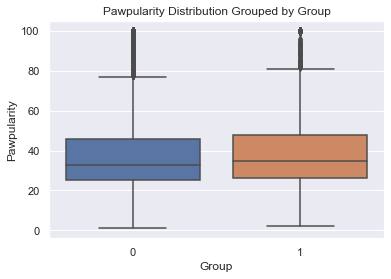

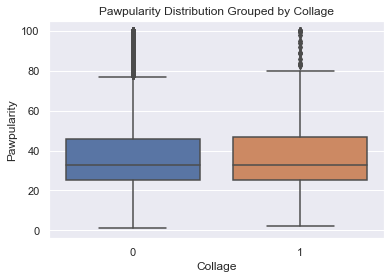

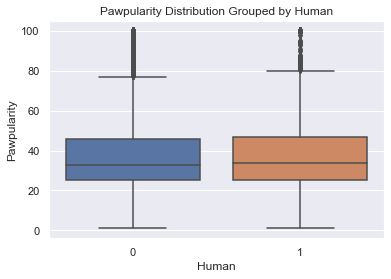

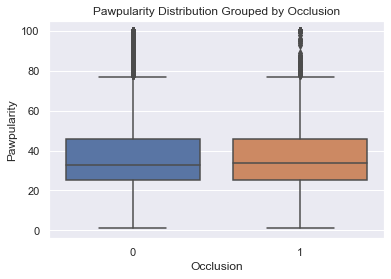

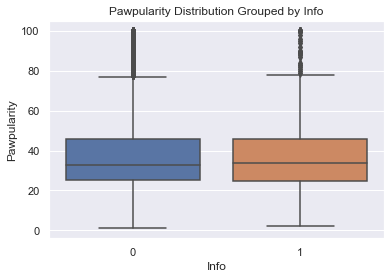

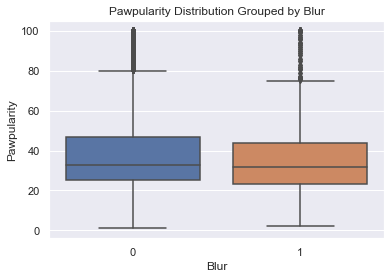

In [51]:
for col in cols_categorical:
    min_length = df[col].value_counts().min()
    df_graph = df.groupby(col, group_keys=False).apply(lambda x: x.sample(min_length))
    sns.boxplot(x=col,
                y='Pawpularity',
                data=df
            ).set(title=f'Pawpularity Distribution Grouped by {col}')
    plt.show()


We saw before that most of our features have under-represented categories. We will take a look at the features where this is most exaggerated. Unless one of presence of one of these variables has a noticable effect on pawpularity, we are likely better off dropping these features. We will take a look at these features and test for a difference of pawpularity means between each group. If the presence of the indicator variable does not seem to effect Pawpularity, we will drop it.


In [52]:
# Identify binarcategorical features, and search for under-represented features.
# Initialize variables.
rare_feature_counts = []
cols_rare = []

# Print samples size.
n_samples = df.shape[0]
print()
print('Number of samples:', n_samples)
print()

# Get feature names.
col_names = list(df.drop(columns=['Pawpularity']))

# Get columns with only two values and print results. 
binary_cols = df.nunique()[df.nunique() <= 2].index
nonbinary_cols = [col for col in col_names if col not in binary_cols]

# Print non-binary features.
print('Number of non-binary features: ', len(nonbinary_cols))
print('Non-binary feature names: ', nonbinary_cols)
print()

# Get binary columns that have the same value at least 95% of the time.
for col in binary_cols:
    # Group by column, count the values, and change to numpy array.
    counts = df.groupby(col).count().iloc[:,0].values
    
    # Find columns with one value occuring in less than 5% of the total samples.
    min_count = np.min(counts)
    if min_count < 0.05 * n_samples:
        rare_feature_counts.append([col, min_count])
        # Save the column names for later.
        cols_rare.append(col)

# Print results.
print('Under-represented categorical features:')

for i in range(0, len(rare_feature_counts)):
    print('\n    Feature:', rare_feature_counts[i][0],
         '\n    Minimum category count:', rare_feature_counts[i][1],
         '\n    Percentage in smallest category:', 100 * rare_feature_counts[i][1] / df.shape[0])
print()



Number of samples: 9912

Number of non-binary features:  1
Non-binary feature names:  ['image']

Under-represented categorical features:

    Feature: Subject Focus 
    Minimum category count: 274 
    Percentage in smallest category: 2.7643260694108154

    Feature: Action 
    Minimum category count: 99 
    Percentage in smallest category: 0.9987893462469734

    Feature: Collage 
    Minimum category count: 492 
    Percentage in smallest category: 4.963680387409201




Feature Name: Subject Focus.


Two sided t-test results:
p-value: 0.3266612619891468



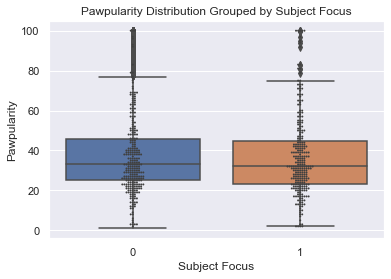

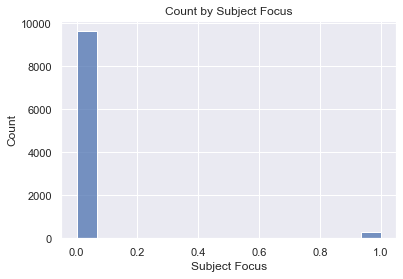

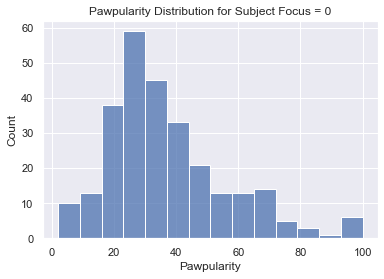

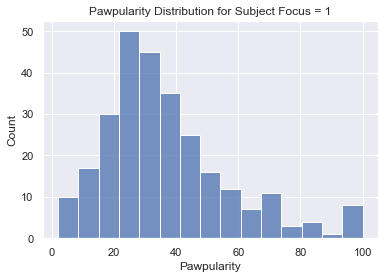


Feature Name: Action.


Two sided t-test results:
p-value: 0.8912861892073636



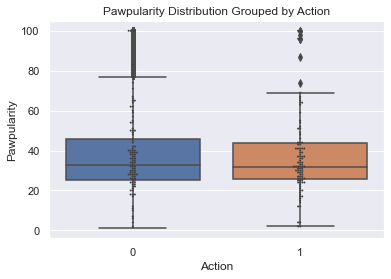

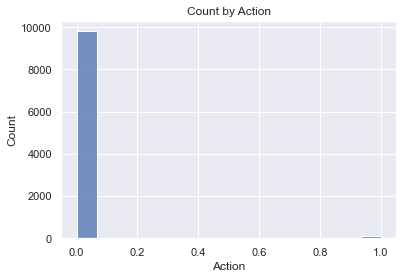

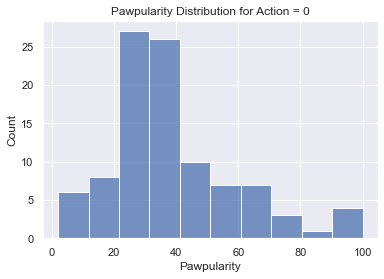

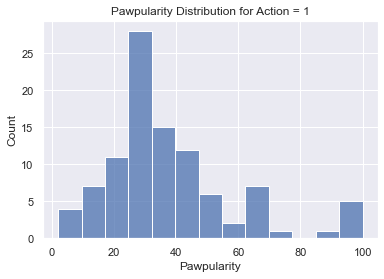


Feature Name: Collage.


Two sided t-test results:
p-value: 0.8630880115884455



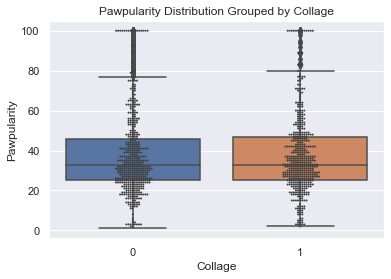

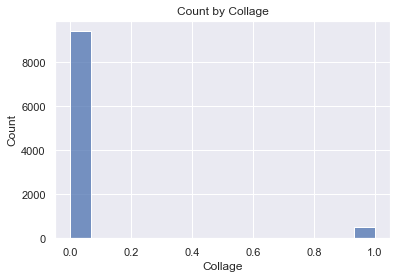

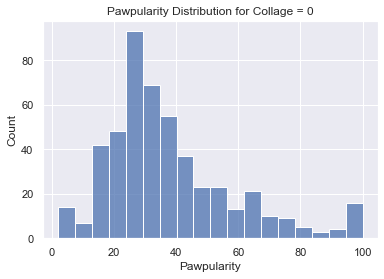

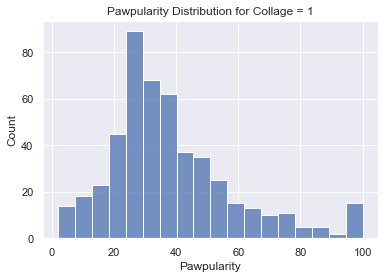

In [53]:
# For each under-represented features, display boxplot and perform t-test to test for a difference in means.
for col in cols_rare:
    
    # Separate each categories and perform t-test to see if mean Pawpularity is different for each group.
    a = df.loc[df[col] == 0, 'Pawpularity']
    b = df.loc[df[col] == 1, 'Pawpularity']
    t_statistic, pval = scipy.stats.ttest_ind(a,b)
    print()
    print(f'Feature Name: {col}.\n')
    print()
    print('Two sided t-test results:')
    print(f'p-value: {pval}')
    print()
    
    # Take subsets to look at the distributions simultaneously
    min_length = np.minimum(len(a), len(b))
    df_sample0  = df.loc[df[col] == 0].sample(min_length, random_state=49)
    df_sample1  = df.loc[df[col] == 1].sample(min_length, random_state=49)
    df_sample = pd.concat([df_sample0, df_sample1], ignore_index=True)

    
    # Create boxplot comparing Pawpularity for each category.
    sns.boxplot(x=col,
                y='Pawpularity',
                data=df)
    sns.swarmplot(x=col,
                  y='Pawpularity',
                  data=df_sample,
                  s=2,
                  color='.25')
    plt.title(f'Pawpularity Distribution Grouped by {col}')
    plt.show()
    
    # Display distribution.
    sns.histplot(df, x=col).set(title=f'Count by {col}')
    plt.show()
    
    # Plot distributions for both groups side by side.
    sns.histplot(df_sample0, x='Pawpularity').set(title=f'Pawpularity Distribution for {col} = 0')
    plt.show()
    sns.histplot(df_sample1,
                x='Pawpularity'
            ).set(title=f'Pawpularity Distribution for {col} = 1')
    plt.show()


In [54]:
# Drop rare columns.
cols_drop = cols_rare.copy()
df.drop(columns=cols_drop, inplace=True)

# Display remaining features.
cols_rem = [col for col in df.columns if col not in ['Id', 'Pawpularity']]
cols_rem = np.array(cols_rem)
cols_rem = list(np.where(cols_rem == 'file_name', 'Image', cols_rem))

print()
print(f'Number of remaining features: {len(cols_rem)}')
print()

print('Remaining Features:')
print()

for col in cols_rem:
    print(f'    {col}')
print()



Number of remaining features: 10

Remaining Features:

    Eyes
    Face
    Near
    Accessory
    Group
    Human
    Occlusion
    Info
    Blur
    image



Our data is now prepared and ready to be split into training, validation, and test sets. We're then ready to design and train our models.


In [55]:
# Separate dataframe into training, validation, and test sets.
df_intermediate, df_test = train_test_split(df, random_state=49, test_size=0.1)

df_train, df_val = train_test_split(df_intermediate, random_state=49, test_size=0.12)

# Save dataset sizes for later.
n_train = df_train.shape[0]
n_val = df_val.shape[0]
n_test = df_test.shape[0]


***

## Modeling

### CNN with Image Augmentation (Model 1)
We first create a standard convolutional neural network with three convolutional layers, two deep layers, two dropout layers, and an output layer. We will use Tensorflow's 'ImageDataGenerator' to rotate, shift, zoom, and flip our images.

This network is meant to represent a standard CNN model used for image classification. Aside from linear activation on our output layer, this is how many data scientists will first approach an image classification problem with only 9,000 samples - image transformations included.


In [56]:
# Create data generators to load and transform images.
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30, # Rotate images up to 30 degrees.
    height_shift_range=0.1, # Shift images vertically by up to 10% of total height.
    width_shift_range=0.1, # Shift images horizontally by up to 10% of total width.
    zoom_range=0.2, # Zoom images by up to 20%.
    horizontal_flip=True, # Flip images horizontally.
    fill_mode='nearest'
)

train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=train_folder,
        x_col="image",
        y_col="Pawpularity",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='raw'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_val,
        directory=train_folder,
        x_col="image",
        y_col="Pawpularity",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='raw'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=train_folder,
        x_col="image",
        y_col=None,
        target_size=(256, 256),
        class_mode=None
)

Found 7849 validated image filenames.
Found 1071 validated image filenames.
Found 992 validated image filenames.


In [57]:
# Build and compile model.
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='linear')
])

cnn_model.summary()
cnn_model.compile(loss = 'mean_squared_error', optimizer='adam')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)       

In [58]:
# # Train model.
# start_time = time.time()
# cnn_history = cnn_model.fit(
#     train_generator,  
#     validation_data=val_generator,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time}")

# # Save our model.
# cnn_model.save('./cnn_model.h5')

# with open('cnn_history.json', 'w') as f:
#     json.dump(cnn_history.history, f)


In [59]:
# Load model.
cnn_path = 'models/cnn_model/'
cnn_model_path = cnn_path + 'cnn_model.h5'
cnn_history_path = cnn_path + 'cnn_history.json'
cnn_model = tf.keras.models.load_model(cnn_model_path)
with open(cnn_history_path, 'r') as f:
    cnn_history = json.load(f)


### CNN without Data Augmentation (Model 2)
We now create a CNN with identical architecture to Model 1, but our data generator will not transform images. All hyperparameters remain constant.


In [60]:
# Create data generators to load and transform images.
training_datagen_2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator_2 = training_datagen_2.flow_from_dataframe(
        dataframe=df_train,
        directory=train_folder,
        x_col="image",
        y_col="Pawpularity",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='raw')

validation_datagen_2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

val_generator_2 = validation_datagen_2.flow_from_dataframe(
        dataframe=df_val,
        directory=train_folder,
        x_col="image",
        y_col="Pawpularity",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='raw')

test_datagen_2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_generator_2 = test_datagen_2.flow_from_dataframe(
        dataframe=df_test,
        directory=train_folder,
        x_col="image",
        y_col=None,
        target_size=(256, 256),
        class_mode=None)


Found 7849 validated image filenames.
Found 1071 validated image filenames.
Found 992 validated image filenames.


In [61]:
# Create and compile model.
cnn_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='linear')
])

cnn_model_2.summary()
cnn_model_2.compile(loss = 'mean_squared_error', optimizer='adam')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)       

In [62]:
# # Train our model.
# start_time = time.time()
# cnn_history_2 = cnn_model_2.fit(
#     train_generator_2,  
#     validation_data=val_generator_2,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time}")

# # Save our model.
# cnn_model_2.save('./cnn_model_2.h5')

# with open('cnn_history_2.json', 'w') as f:
#     json.dump(cnn_history_2.history, f)


In [63]:
# Load model.
cnn_2_path = 'models/cnn_model_2/'
cnn_model_2_path = cnn_2_path + 'cnn_model_2.h5'
cnn_history_2_path = cnn_2_path + 'cnn_history_2.json'
cnn_model_2 = tf.keras.models.load_model(cnn_model_2_path)
with open(cnn_history_2_path, 'r') as f:
    cnn_history_2 = json.load(f)


### Multi-input (Model 3)
Another reason one might favor using only un-augmented images for this problem is because it makes it easier to include our categorical features. While we could spend the time to find out which categorical features are invariant under various image transformations, using un-augmented images for training means that we get these extra features free of charge.

We now create a model to include these categorical features. The network consists of three parts:

    1. a CNN architecture identical to that of Model 1 and Model 2 that accepts our image inputs
    2. a full connected network with three hidden layers that accepts categorical inputs
    3. a concatenation layer that accepts the ouput of both 1. and 2., and outputs a final prediction.


Since we will no longer be using a Tensorflow data generator, we will have to process the data manually. This includes processing images and separating image and categorical inputs.


In [64]:
def process_image(file_name):
    # Retrieve PIL format image from file name.
    image = tf.keras.preprocessing.image.load_img(file_name, target_size=[256,256])
    
    # Convert PIL into a scaled numpy array.
    input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    
    return input_arr

def preprocessDataFrame(df, labels=True):
    df_ = df.copy()
    df_['image'] = df_['image'].map(lambda id: folder_path + 'train/' + id)

    X = df_.drop(columns=['Pawpularity', 'image']).copy()
    
    for col in cols_drop:
        try:
            X = X.drop(columns=[col])
        except KeyError:
            pass
    
    X = X.values.astype("float32")
    
    images_ = df_[['image']].copy().values
    images_ = [process_image(image[0]) for image in images_]
    images = np.asarray(images_)
    
    if labels:
        y = df_[['Pawpularity']].copy()
        y = np.asarray(y).astype("float32")
        
        return X, images, y
    
    else:
        return X, images

X_train_processed, images_train_processed, y_train_processed = preprocessDataFrame(df_train)
X_val_processed, images_val_processed, y_val_processed = preprocessDataFrame(df_val)
X_test_processed, images_test_processed, y_test_processed = preprocessDataFrame(df_test)
    

In [65]:
# Create model.
# Categorical input.
cat_input = tf.keras.layers.Input(shape=(9,))

# Two dense layers and a dropout layer.
cat_deep1 = tf.keras.layers.Dense(6, activation='relu')(cat_input)
cat_dropout1 = tf.keras.layers.Dropout(rate=0.3)(cat_deep1)
cat_deep2 = tf.keras.layers.Dense(6, activation='relu')(cat_dropout1)

# Third hidden layer serving as the output for categorical features.
cat_output = tf.keras.layers.Dense(6, activation='relu')(cat_deep2)

# Image input
cnn_input = tf.keras.layers.Input(shape=(256,256,3,))

# Three convolutional layers with one dropout layer.
cnn_conv1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(cnn_input)
cnn_maxpool1 = tf.keras.layers.MaxPooling2D(2, 2)(cnn_conv1)

cnn_conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(cnn_maxpool1)
cnn_dropout1 = tf.keras.layers.Dropout(rate=0.3)(cnn_conv2)
cnn_maxpool2 = tf.keras.layers.MaxPooling2D(2,2)(cnn_dropout1)

cnn_conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(cnn_maxpool2)
cnn_maxpool3 = tf.keras.layers.MaxPooling2D(2,2)(cnn_conv3)

# Flatten and dropout layer.
cnn_flatten1 = tf.keras.layers.Flatten()(cnn_maxpool3)
cnn_dropout3 = tf.keras.layers.Dropout(rate=0.3)(cnn_flatten1)

# Additional dense layers and output.
cnn_dense1 = tf.keras.layers.Dense(256, activation='relu')(cnn_dropout3)
cnn_output = tf.keras.layers.Dense(64, activation='relu')(cnn_dense1)

# Concatenate.
concat = tf.keras.layers.concatenate([cat_output, cnn_output])
output = tf.keras.layers.Dense(1, activation='linear', name='output')(concat)

# Build model from layers.
multi_model = tf.keras.Model(inputs=[cat_input, cnn_input], outputs=[output])
multi_model.summary()

# Compile our model using mean squared error and adam optimization.
multi_model.compile(loss = 'mean_squared_error', optimizer='adam')


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 254, 254, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 127, 127, 64) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 125, 125, 64) 36928       max_pooling2d_17[0][0]           
____________________________________________________________________________________________

In [66]:
# # Train our model.
# start_time = time.time()

# multi_history = multi_model.fit(
#     (X_train_processed, images_train_processed),
#     y_train_processed,
#     validation_data=((X_val_processed, images_val_processed), y_val_processed),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f'Elapsed time: {elapsed_time}')

# # Save our model.
# multi_model.save('./multi_model.h5')

# with open('multi_history.json', 'w') as f:
#     json.dump(multi_history.history, f)


In [67]:
# Load model.
multi_path = 'models/multi_model/'
multi_model_path = multi_path + 'multi_model.h5'
multi_history_path = multi_path + 'multi_history.json'
multi_model = tf.keras.models.load_model(multi_model_path)
with open(multi_history_path, 'r') as f:
    multi_history = json.load(f)


***

# Model Comparisons and Tweaking
Let's take a look at our models' performances and see if we can gain any insight. We will then make some modifications based on these insights.


### Model 1 Results

CNN with Image Augmentation.


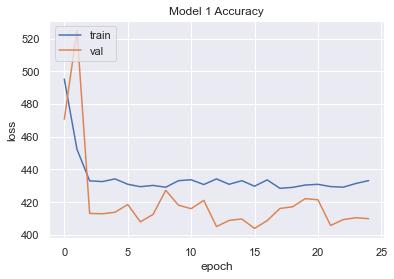

2022-03-19 17:11:58.660755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


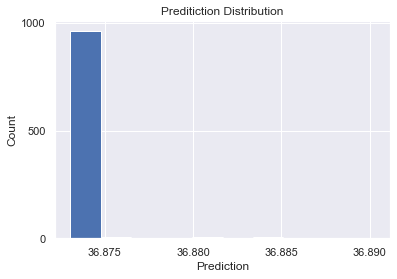

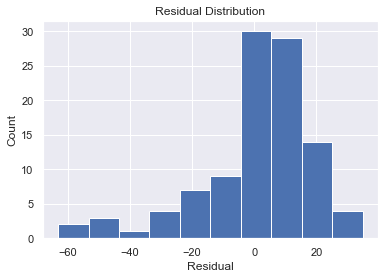

Root Mean Squared Error: 20.74456722535536
Mean Absolute Error: 15.127143352262435



In [68]:
print('CNN with Image Augmentation.')

plt.plot(cnn_history['loss'])
plt.plot(cnn_history['val_loss'])
plt.title('Model 1 Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_cnn = cnn_model.predict(test_generator)
preds_cnn_series = pd.Series(preds_cnn.flatten())
residuals_cnn = preds_cnn_series - df_test['Pawpularity']

plt.hist(preds_cnn)
plt.locator_params(nbins=4)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_cnn)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_cnn = np.sqrt(mean_squared_error(preds_cnn_series.values, df_test['Pawpularity'].values))
r2_cnn = r2_score(preds_cnn_series.values, df_test['Pawpularity'].values)
mae_cnn = mean_absolute_error(preds_cnn_series.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_cnn}")
print(f"Mean Absolute Error: {mae_cnn}")
print()


### Model 2 Results

CNN without Image Augmentation.


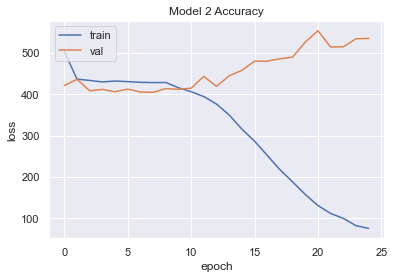

2022-03-19 17:12:05.531529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


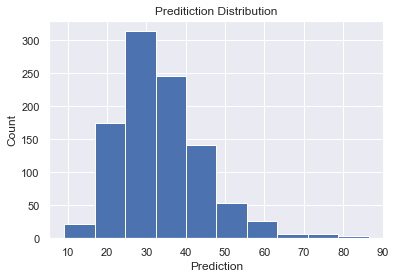

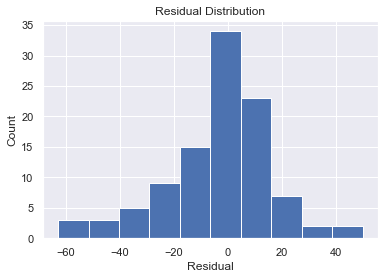

Root Mean Squared Error: 24.17578655432344
Mean Absolute Error: 17.881399027762875



In [69]:
print('CNN without Image Augmentation.')

plt.plot(cnn_history_2['loss'])
plt.plot(cnn_history_2['val_loss'])
plt.title('Model 2 Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_cnn_2 = cnn_model_2.predict(test_generator_2)
preds_cnn_series_2 = pd.Series(preds_cnn_2.flatten())
residuals_cnn_2 = preds_cnn_series_2 - df_test['Pawpularity']

plt.hist(preds_cnn_2)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_cnn_2)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_cnn_2 = np.sqrt(mean_squared_error(preds_cnn_series_2.values, df_test['Pawpularity'].values))
r2_cnn_2 = r2_score(preds_cnn_series_2.values, df_test['Pawpularity'].values)
mae_cnn_2 = mean_absolute_error(preds_cnn_series_2.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_cnn_2}")
print(f"Mean Absolute Error: {mae_cnn_2}")
print()


### Model 3 Results

Multi-input Network without Data Augmentation


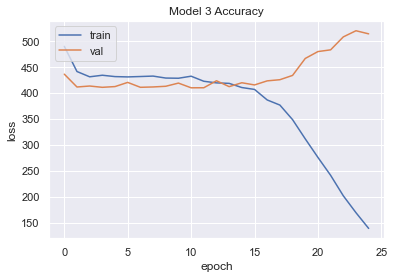

2022-03-19 17:12:11.971023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


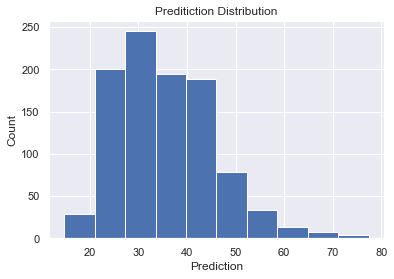

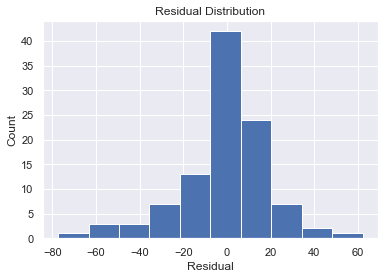

Root Mean Squared Error: 22.704984893331247
Mean Absolute Error: 16.861406457039617



In [70]:
print('Multi-input Network without Data Augmentation')

plt.plot(multi_history['loss'])
plt.plot(multi_history['val_loss'])
plt.title('Model 3 Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_multi = multi_model.predict((X_test_processed, images_test_processed))
preds_multi_series = pd.Series(preds_multi.flatten())
residuals_multi = preds_multi_series - df_test['Pawpularity']

plt.hist(preds_multi)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_multi)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_multi = np.sqrt(mean_squared_error(preds_multi_series.values, df_test['Pawpularity'].values))
r2_multi = r2_score(preds_multi_series.values, df_test['Pawpularity'].values)
mae_multi = mean_absolute_error(preds_multi_series.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_multi}")
print(f"Mean Absolute Error: {mae_multi}")
print()


### Comparison and Discussion

First and foremost, you may notice that validation loss is less than training loss for each model, at least until they start overfitting. This is likely of little concern, since our models use fairly aggressive dropout.

Looking at Model 1, we see that we are producing only constant predictions - in other words, our model doesn't seem to have learned anything at all. This suggests that image augmentation may not be an effective method for this problem, but for the sake of fairness we will retrain the model with early stopping to see if this helps.

Our loss curves for Model 2 and Model 3 show some dramatic issues with overfitting our data, which makes sense considering we have so few training images. We'll take some basic steps to address this issue now. Thanks to our loss curves we see that we may be able fix this issue with early stopping. Before doing that, however, we'll first train a more simple CNN architecture with fewer hidden layers. This will both display a different approach to addressing overfitting and may give us an indication as to the model complexity required for the problem.


### Simple CNN (Model 4)
We create and train a simpler model with only two convolutional layers. Note that this model is being trained on un-transformed images only.

In [71]:
# Create data generators and callbacks.
training_datagen_3 = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator_3 = training_datagen_3.flow_from_dataframe(
        dataframe=df_train,
        directory=train_folder,
        x_col="image",
        y_col="Pawpularity",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='raw')

validation_datagen_3 = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

val_generator_3 = validation_datagen_3.flow_from_dataframe(
        dataframe=df_val,
        directory=train_folder,
        x_col="image",
        y_col="Pawpularity",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='raw')

test_datagen_3 = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_generator_3 = test_datagen_3.flow_from_dataframe(
        dataframe=df_test,
        directory=train_folder,
        x_col="image",
        y_col=None,
        target_size=(256, 256),
        class_mode=None)

# Create callback to save checkpoints.
call_back = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath='cnn_model_3_checkpoint',
      save_best_only=True,
      monitor='val_loss'
  )
]


Found 7849 validated image filenames.
Found 1071 validated image filenames.
Found 992 validated image filenames.


In [72]:
# CNN with two convolutional layers.
cnn_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='linear')
])

cnn_model_3.summary()
cnn_model_3.compile(loss = 'mean_squared_error', optimizer='adam')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
dropout_16 (Dropout)         (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 246016)           

In [73]:
# # Train our model.
# start_time = time.time()
# cnn_history_3 = cnn_model_3.fit(
#     train_generator_3,  
#     validation_data=val_generator_3,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     callbacks=call_back,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time}")

# # Save our model.
# cnn_model_3.save('./cnn_model_3.h5')

# with open('cnn_history_3.json', 'w') as f:
#     json.dump(cnn_history_3.history, f)


In [74]:
# Load model.
cnn_3_path = 'models/cnn_model_3/'
cnn_model_3_path = cnn_3_path + 'cnn_model_3.h5'
cnn_history_3_path = cnn_3_path + 'cnn_history_3.json'
cnn_model_3 = tf.keras.models.load_model(cnn_model_3_path)
with open(cnn_history_3_path, 'r') as f:
    cnn_history_3 = json.load(f)


### Callbacks
We create callbacks to perform early stopping and save checkpoints, then reinitialize Model 1, Model 2 and Model 3 before retraining.

In [75]:
# Create early stopping and checkpoint callbacks.
call_backs_cnn = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath='cnn_model_checkpoint',
      save_best_only=True,
      monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', 
      patience=10, 
      min_delta=1,
      restore_best_weights=True
    )
]

call_backs_cnn_aug = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath='cnn_model_2_checkpoint',
      save_best_only=True,
      monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', 
      patience=10, 
      min_delta=1,
      restore_best_weights=True
    )
]

call_backs_multi = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath='multi_model_checkpoint',
      save_best_only=True,
      monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', 
      patience=10, 
      min_delta=1,
      restore_best_weights=True
    )
]


In [76]:
# Reinitialize models.
# Function reference: 'https://stackoverflow.com/questions/63435679/reset-all-weights-of-keras-model'
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

reinitialize(cnn_model)
reinitialize(cnn_model_2)
reinitialize(multi_model)


### Retrain Model 1 with Early Stopping

In [77]:
# # Train our model.
# start_time = time.time()
# cnn_history_5 = cnn_model_2.fit(
#     train_generator_2,  
#     validation_data=val_generator_2,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     callbacks=call_backs_cnn,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time}")

# # Save our model.
# cnn_model_2.save('./multi_model_5.h5')

# with open('multi_history_5.json', 'w') as f:
#     json.dump(multi_history_5.history, f)


In [78]:
# Load model.
cnn_5_path = 'models/cnn_model_5/'
cnn_model_5_path = cnn_5_path + 'cnn_model_5.h5'
cnn_history_5_path = cnn_5_path + 'cnn_history_5.json'
cnn_model_5 = tf.keras.models.load_model(cnn_model_5_path)
with open(cnn_history_5_path, 'r') as f:
    cnn_history_5 = json.load(f)


### Retrain Model 2 with Early Stopping

In [79]:
# # Train our model.
# # Reinitialize model.
# reinitialize(cnn_model_2)

# start_time = time.time()
# cnn_history_4 = cnn_model_2.fit(
#     train_generator_2,  
#     validation_data=val_generator_2,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     callbacks=call_backs_cnn_aug,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time}")

# # Save our model.
# cnn_model_2.save('./multi_model_4.h5')

# with open('multi_history_4.json', 'w') as f:
#     json.dump(multi_history_4.history, f)


In [80]:
# Load model.
cnn_4_path = 'models/cnn_model_4/'
cnn_model_4_path = cnn_4_path + 'cnn_model_4.h5'
cnn_history_4_path = cnn_4_path + 'cnn_history_4.json'
cnn_model_4 = tf.keras.models.load_model(cnn_model_4_path)
with open(cnn_history_4_path, 'r') as f:
    cnn_history_4 = json.load(f)


### Retrain Model 3 with Early Stopping

In [81]:
# # Train our model.
# start_time = time.time()

# multi_history_2 = multi_model.fit(
#     (X_train_processed, images_train_processed),
#     y_train_processed,
#     validation_data=((X_val_processed, images_val_processed), y_val_processed),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=n_train // BATCH_SIZE,
#     validation_steps=n_val // BATCH_SIZE,
#     callbacks=call_backs_multi,
#     verbose = 1
# )

# elapsed_time = time.time() - start_time
# print(f'Elapsed time: {elapsed_time}')

# # Save our model.
# multi_model.save('./multi_model_2.h5')

# with open('multi_history_2.json', 'w') as f:
#     json.dump(multi_history_2.history, f)


In [82]:
# Load model.
multi_path_2 = 'models/multi_model_2/'
multi_model_2_path = multi_path_2 + 'multi_model_2.h5'
multi_history_2_path = multi_path_2 + 'multi_history_2.json'
multi_model_2 = tf.keras.models.load_model(multi_model_2_path)
with open(multi_history_2_path, 'r') as f:
    multi_history_2 = json.load(f)


***

# Final Results
We now show the results from retraining our original three models, as well as the results from our new model.

### Model 1 Results

Model 1 - CNN with Early Stopping and Image Augmentation.


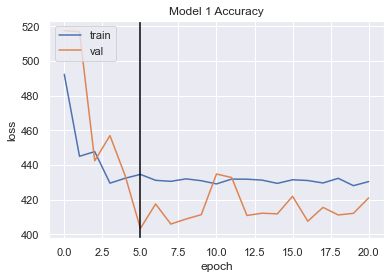

2022-03-19 17:12:19.381171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


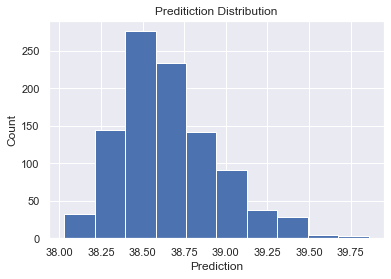

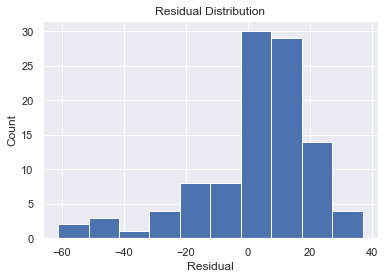

Root Mean Squared Error: 20.66445828922556
Mean Absolute Error: 15.531228646155327


In [83]:
# Plot results.
print('Model 1 - CNN with Early Stopping and Image Augmentation.')

plt.plot(cnn_history_5['loss'])
plt.plot(cnn_history_5['val_loss'])
plt.axvline(x=5, color='black')
plt.title('Model 1 Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_cnn_5 = cnn_model_5.predict(test_generator_2)
preds_cnn_series_5 = pd.Series(preds_cnn_5.flatten())
residuals_cnn_5 = preds_cnn_series_5 - df_test['Pawpularity']

plt.hist(preds_cnn_5)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_cnn_5)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_cnn_5 = np.sqrt(mean_squared_error(preds_cnn_series_5.values, df_test['Pawpularity'].values))
r2_cnn_5 = r2_score(preds_cnn_series_5.values, df_test['Pawpularity'].values)
mae_cnn_5 = mean_absolute_error(preds_cnn_series_5.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_cnn_5}")
print(f"Mean Absolute Error: {mae_cnn_5}")

### Model 2 Results

Model 2 - CNN with Early Stopping and without Image Augmentation.


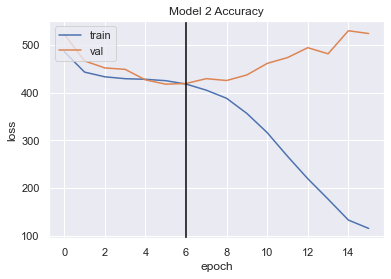

2022-03-19 17:12:26.747631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


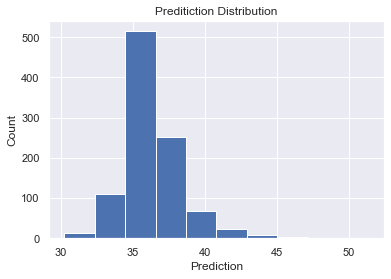

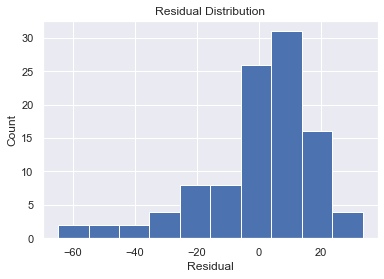

Root Mean Squared Error: 20.879977848280472
Mean Absolute Error: 15.093152611486373


In [84]:
# Plot results.
print('Model 2 - CNN with Early Stopping and without Image Augmentation.')

plt.plot(cnn_history_4['loss'])
plt.plot(cnn_history_4['val_loss'])
plt.axvline(x=6, color='black')
plt.title('Model 2 Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_cnn_4 = cnn_model_4.predict(test_generator_2)
preds_cnn_series_4 = pd.Series(preds_cnn_4.flatten())
residuals_cnn_4 = preds_cnn_series_4 - df_test['Pawpularity']

plt.hist(preds_cnn_4)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_cnn_4)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_cnn_4 = np.sqrt(mean_squared_error(preds_cnn_series_4.values, df_test['Pawpularity'].values))
r2_cnn_4 = r2_score(preds_cnn_series_4.values, df_test['Pawpularity'].values)
mae_cnn_4 = mean_absolute_error(preds_cnn_series_4.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_cnn_4}")
print(f"Mean Absolute Error: {mae_cnn_4}")

### Model 3 Results

Model 3 - Multi-input CNN with early stopping and without Data Augmentation


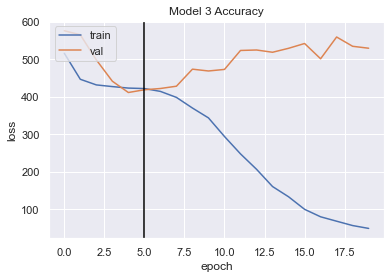

2022-03-19 17:12:33.201814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


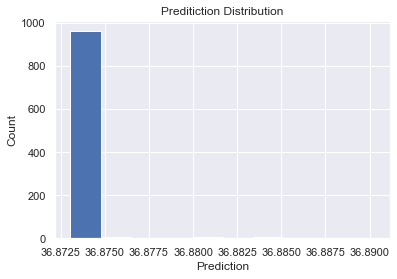

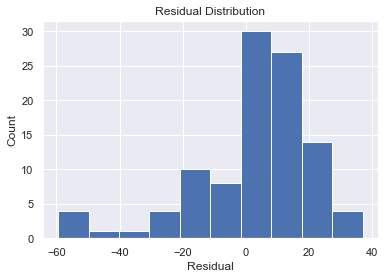

Root Mean Squared Error: 20.648868587400557
Mean Absolute Error: 15.476038809745543


In [85]:
# Plot results.
print('Model 3 - Multi-input CNN with early stopping and without Data Augmentation')

plt.plot(multi_history_2['loss'])
plt.plot(multi_history_2['val_loss'])
plt.axvline(x=5, color='black')
plt.title('Model 3 Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_multi_2 = multi_model_2.predict((X_test_processed, images_test_processed))
preds_multi_2_series = pd.Series(preds_multi_2.flatten())
residuals_multi_2 = preds_multi_2_series - df_test['Pawpularity']

plt.hist(preds_cnn)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_multi_2)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_multi_2 = np.sqrt(mean_squared_error(preds_multi_2_series.values, df_test['Pawpularity'].values))
r2_multi_2 = r2_score(preds_multi_2_series.values, df_test['Pawpularity'].values)
mae_multi_2 = mean_absolute_error(preds_multi_2_series.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_multi_2}")
print(f"Mean Absolute Error: {mae_multi_2}")

### Model 4 Results

Simple CNN


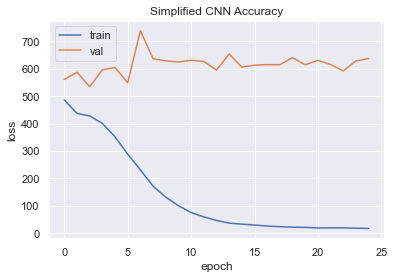

2022-03-19 17:12:39.265555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


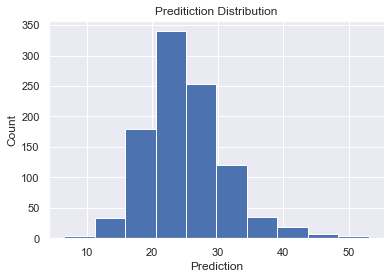

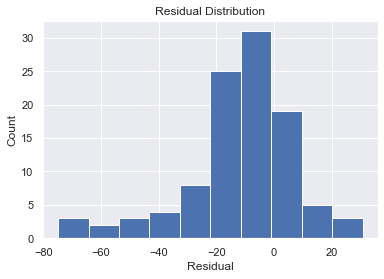

Root Mean Squared Error: 25.372268133266868
Mean Absolute Error: 18.02362817237454


In [86]:
print('Simple CNN')

plt.plot(cnn_history_3['loss'])
plt.plot(cnn_history_3['val_loss'])
plt.title('Simplified CNN Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds_cnn_3 = cnn_model_3.predict(test_generator_3)
preds_cnn_series_3 = pd.Series(preds_cnn_3.flatten())
residuals_cnn_3 = preds_cnn_series_3 - df_test['Pawpularity']

plt.hist(preds_cnn_3)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Preditiction Distribution')
plt.show()

plt.hist(residuals_cnn_3)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

rmse_cnn_3 = np.sqrt(mean_squared_error(preds_cnn_series_3.values, df_test['Pawpularity'].values))
r2_cnn_3 = r2_score(preds_cnn_series_3.values, df_test['Pawpularity'].values)
mae_cnn_3 = mean_absolute_error(preds_cnn_series_3.values, df_test['Pawpularity'].values)

print(f"Root Mean Squared Error: {rmse_cnn_3}")
print(f"Mean Absolute Error: {mae_cnn_3}")

# Conclusion
Unfortunately it looks like the problem of overfitting may be more difficult to address than we had hoped. Model 4 did not see improved performance, and there are indications that the local minimum that Model 1, Model 2, Model 3 were converging towards early in their training was just the constant solution.

So it looks like we were not able to overcome the problem of sample size when predicting Pawpularity by simply transforming our images. Moreover, Model 2, Model 3, and Model 4 all had insufficient sample size to be effecitely trained without overfitting.

It is important to note that this was not an exhaustive investigation - after all, we only looked at three model architectures with no hyperparameter optimization whatsoever. However, this investigation is evidence of what we were pretty sure of in the first place: while training a model from scratch can be informative and useful, if you want to take a deep learning approach to this competiition then it would be wise to utilize a pretrained model.
